In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np

# Locating File Path
PATH = "/kaggle/input/brazilian-ecommerce"

orders      = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
products    = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
sellers     = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
customers   = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
payments    = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
reviews     = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")  

# Change in Terminologies
for df, name in [(orders,"orders"),(order_items,"order_items"),(products,"products"),
                 (sellers,"sellers"),(customers,"customers"),(payments,"payments")]:
    print(name, df.shape)


orders (99441, 8)
order_items (112650, 7)
products (32951, 9)
sellers (3095, 4)
customers (99441, 5)
payments (103886, 5)


In [3]:
# Cleaning
# 1.Changing the return status 
orders['is_returned'] = orders['order_status'].isin(['canceled','unavailable']).astype(int)

# 2.Parsing the timestamps 
dt_cols = ['order_purchase_timestamp','order_approved_at',
           'order_delivered_customer_date','order_estimated_delivery_date',
           'shipping_limit_date']
for c in dt_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')
    if c in order_items.columns:
        order_items[c] = pd.to_datetime(order_items[c], errors='coerce')

# 3.Aggregating items per order 
items_agg = (order_items
             .groupby('order_id')
             .agg(total_price=('price','sum'),
                  total_freight=('freight_value','sum'),
                  first_product=('product_id','first'),
                  first_seller=('seller_id','first'),
                  n_items=('order_item_id','count'))
            ).reset_index()

# 4.Maping product -> category
prod_cat = products[['product_id','product_category_name']].drop_duplicates()
items_agg = items_agg.merge(prod_cat, left_on='first_product', right_on='product_id', how='left')

# 5.Adding seller & customer states
items_agg = items_agg.merge(sellers[['seller_id','seller_state']].drop_duplicates(),
                            left_on='first_seller', right_on='seller_id', how='left')

orders2 = (orders
           .merge(items_agg, on='order_id', how='left')
           .merge(customers[['customer_id','customer_state']], on='customer_id', how='left')
          )

# 6.Payments (keeping main payment_type per order)
main_pay = (payments
            .sort_values(['order_id','payment_value'], ascending=[True,False])
            .drop_duplicates('order_id'))
orders2 = orders2.merge(main_pay[['order_id','payment_type','payment_value']], on='order_id', how='left')

# Implementing some simple delivery features 
orders2['days_to_ship'] = (orders2['order_approved_at'] - orders2['order_purchase_timestamp']).dt.days
orders2['days_to_deliver'] = (orders2['order_delivered_customer_date'] - orders2['order_approved_at']).dt.days
orders2['promised_days'] = (orders2['order_estimated_delivery_date'] - orders2['order_purchase_timestamp']).dt.days
orders2['delivery_delay'] = (orders2['order_delivered_customer_date'] - orders2['order_estimated_delivery_date']).dt.days

orders2.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,is_returned,total_price,...,product_category_name,seller_id,seller_state,customer_state,payment_type,payment_value,days_to_ship,days_to_deliver,promised_days,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,29.99,...,utilidades_domesticas,3504c0cb71d7fa48d967e0e4c94d59d9,SP,SP,voucher,18.59,0.0,8.0,15,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0,118.70,...,perfumaria,289cdb325fb7e7f891c38608bf9e0962,SP,BA,boleto,141.46,1.0,12.0,19,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0,159.90,...,automotivo,4869f7a5dfa277a7dca6462dcf3b52b2,SP,GO,credit_card,179.12,0.0,9.0,26,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0,45.00,...,pet_shop,66922902710d126a0e7d26b0e3805106,MG,RN,credit_card,72.20,0.0,13.0,26,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0,19.90,...,papelaria,2c9e548be18521d1c43cde1c582c6de8,SP,SP,credit_card,28.62,0.0,2.0,12,-10.0


In [4]:
# Analysis (Return % by category/state/payment)
def rate_table(df, by, k=15):
    t = (df.groupby(by)
           .agg(orders=('order_id','nunique'),
                returned=('is_returned','sum'))
           .assign(return_rate_pct=lambda x: 100*x['returned']/x['orders'])
           .sort_values('return_rate_pct', ascending=False)
        )
    return t.head(k).reset_index()

by_cat   = rate_table(orders2, 'product_category_name')
by_seller= rate_table(orders2, 'seller_state')
by_cust  = rate_table(orders2, 'customer_state')
by_pay   = rate_table(orders2, 'payment_type')

by_cat.head(10), by_seller.head(10), by_cust.head(10), by_pay


(                           product_category_name  orders  returned  \
 0                                       pc_gamer       7         1   
 1  portateis_cozinha_e_preparadores_de_alimentos      14         1   
 2                                fraldas_higiene      27         1   
 3                                   dvds_blu_ray      59         2   
 4                                 telefonia_fixa     217         3   
 5                         livros_interesse_geral     509         7   
 6                             eletrodomesticos_2     233         3   
 7                          instrumentos_musicais     624         8   
 8                                eletroportateis     627         8   
 9               construcao_ferramentas_seguranca     162         2   
 
    return_rate_pct  
 0        14.285714  
 1         7.142857  
 2         3.703704  
 3         3.389831  
 4         1.382488  
 5         1.375246  
 6         1.287554  
 7         1.282051  
 8         1.275917

In [5]:
# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

model_df = orders2.copy()

# Keeping rows with target and features present
feat_num = ['total_price','total_freight','n_items','days_to_ship','days_to_deliver','delivery_delay']
feat_cat = ['product_category_name','payment_type','seller_state','customer_state']

model_df = model_df.dropna(subset=['is_returned'] + feat_num)  # numeric must exist
# Filling missing categories with 'unknown'
for c in feat_cat:
    model_df[c] = model_df[c].fillna('unknown')

X = model_df[feat_num + feat_cat]
y = model_df['is_returned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), feat_cat),
        ('num', 'passthrough', feat_num)
    ]
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('lr', LogisticRegression(max_iter=500))
])

clf.fit(X_train, y_train)

# Evaluating
proba = clf.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, (proba>=0.5).astype(int)))


ROC-AUC: 0.8613461059965165
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24114
           1       0.00      0.00      0.00         2

    accuracy                           1.00     24116
   macro avg       0.50      0.50      0.50     24116
weighted avg       1.00      1.00      1.00     24116



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
#Working through SQL queries 
import sqlite3
import pandas as pd

# Creating connection
conn = sqlite3.connect(":memory:")  # use in-memory database
cursor = conn.cursor()

# Locating File Path
PATH = "/kaggle/input/brazilian-ecommerce"

orders      = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
products    = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
sellers     = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
customers   = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
payments    = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
reviews     = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")  

orders.to_sql("orders", conn, index=False, if_exists="replace")
order_items.to_sql("order_items", conn, index=False, if_exists="replace")
products.to_sql("products", conn, index=False, if_exists="replace")
sellers.to_sql("sellers", conn, index=False, if_exists="replace")
payments.to_sql("payments", conn, index=False, if_exists="replace")
customers.to_sql("customers", conn, index=False, if_exists="replace")


99441

In [11]:
# Overall Return Rate
query = """
SELECT 
    COUNT(*) AS total_orders,
    SUM(CASE WHEN order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) AS returned_orders,
    ROUND(100.0 * SUM(CASE WHEN order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) / COUNT(*), 2) AS return_rate_pct
FROM orders;
"""
pd.read_sql(query, conn)


,total_orders,returned_orders,return_rate_pct
0,99441,1234,1.24


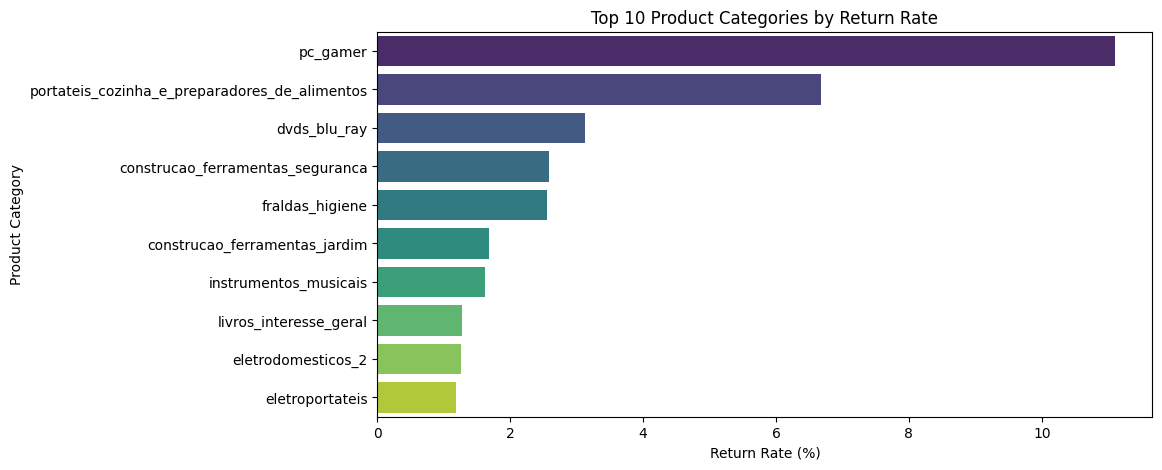

In [23]:
# Return Rate by Product Category (Top 10 Categories)
import matplotlib.pyplot as plt
import seaborn as sns

query = """
SELECT p.product_category_name,
       ROUND(100.0 * SUM(CASE WHEN o.order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) / COUNT(*), 2) AS return_rate_pct
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY return_rate_pct DESC
LIMIT 10;
"""
df_cat = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
sns.barplot(x="return_rate_pct", y="product_category_name", data=df_cat, palette="viridis")
plt.xlabel("Return Rate (%)")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories by Return Rate")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


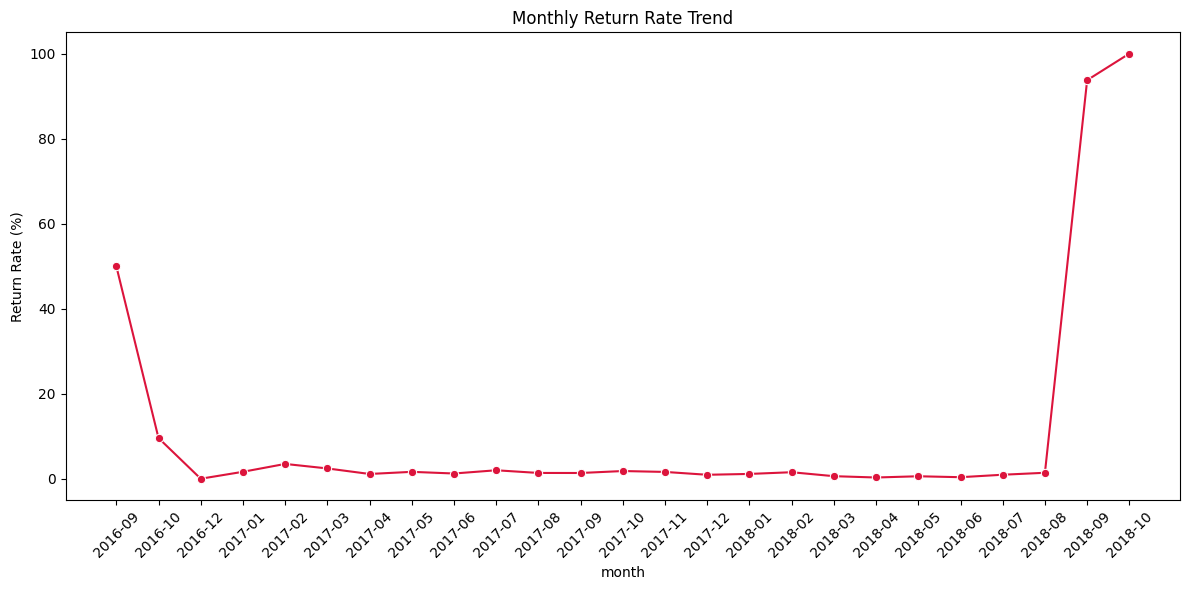

In [24]:
# Monthly Return Trend
query = """
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month,
       ROUND(100.0 * SUM(CASE WHEN order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) / COUNT(*), 2) AS return_rate_pct
FROM orders
GROUP BY month
ORDER BY month;
"""
df_month = pd.read_sql(query, conn)

plt.figure(figsize=(12,6))
sns.lineplot(x="month", y="return_rate_pct", data=df_month, marker="o", color="crimson")
plt.xticks(rotation=45)
plt.ylabel("Return Rate (%)")
plt.title("Monthly Return Rate Trend")
plt.tight_layout()
plt.show()


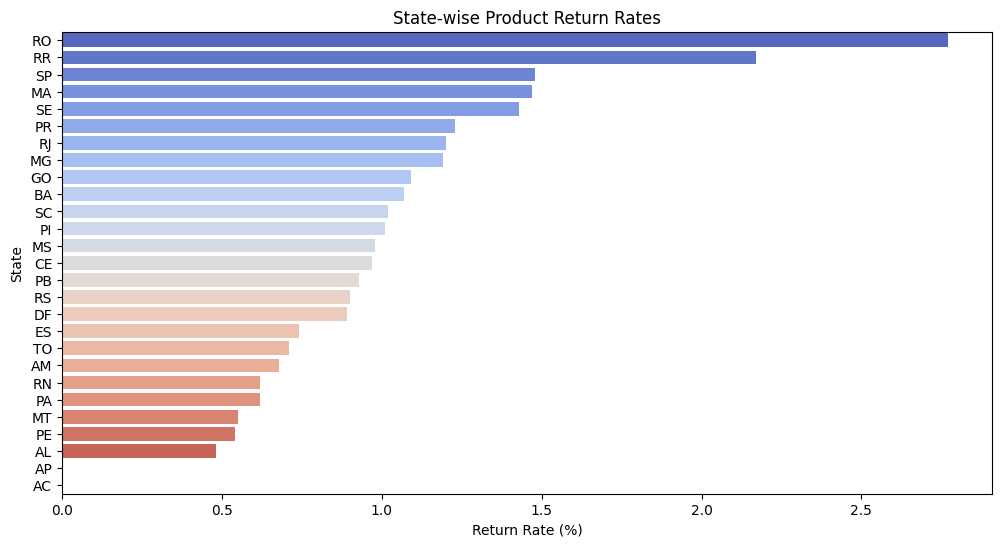

In [25]:
# Statewise return rate
query = """
SELECT c.customer_state,
       COUNT(*) AS total_orders,
       SUM(CASE WHEN o.order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) AS returned_orders,
       ROUND(100.0 * SUM(CASE WHEN o.order_status IN ('canceled','unavailable') THEN 1 ELSE 0 END) / COUNT(*), 2) AS return_rate_pct
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_state
ORDER BY return_rate_pct DESC;
"""
df_state = pd.read_sql(query, conn)
plt.figure(figsize=(12,6))
sns.barplot(x="return_rate_pct", y="customer_state", data=df_state, palette="coolwarm")
plt.xlabel("Return Rate (%)")
plt.ylabel("State")
plt.title("State-wise Product Return Rates")
plt.show()


In [26]:
# CSV of high-risk products/customers 
# Predicting probabilities for all rows in model_df
all_proba = clf.predict_proba(X)[:,1]

model_df['return_probability'] = all_proba


In [27]:
high_risk = model_df[model_df['return_probability'] > 0.6]


In [28]:
# High-risk products
high_risk_products = (high_risk.groupby('product_category_name')
                      .agg(high_risk_orders=('order_id','nunique'),
                           avg_return_prob=('return_probability','mean'))
                      .sort_values('avg_return_prob', ascending=False)
                      .reset_index())

# High-risk customers
high_risk_customers = (high_risk.groupby('customer_state')
                       .agg(high_risk_orders=('order_id','nunique'),
                            avg_return_prob=('return_probability','mean'))
                       .sort_values('avg_return_prob', ascending=False)
                       .reset_index())


In [29]:
high_risk_products.to_csv("high_risk_products.csv", index=False)
high_risk_customers.to_csv("high_risk_customers.csv", index=False)

print("✅ CSV files saved: high_risk_products.csv, high_risk_customers.csv")


✅ CSV files saved: high_risk_products.csv, high_risk_customers.csv
